In [2]:
from langchain_chroma import Chroma
import numpy as np
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
import pandas as pd
import os
from PIL import Image
import torch
import uuid
import base64
from io import BytesIO
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
multimodal_ef = OpenCLIPEmbeddings(model_name="coca_ViT-L-14", checkpoint="mscoco_finetuned_laion2B-s13B-b90k",device='cuda')

In [ ]:
# multimodal_ef = OpenCLIPEmbeddings(
#     model_name="coca_ViT-L-14",
#     checkpoint="/home/yoosuf/.cache/huggingface/hub/models--laion--mscoco_finetuned_CoCa-ViT-L-14-laion2B-s13B-b90k/snapshots/f895105fb18cf5ea3ba7a1172966e4cc0ad8d743/open_clip_pytorch_model.bin",
#     pretrained=True,
#     device=device
# )

In [5]:

chroma_vector_store = Chroma(
    collection_name="img_collection",
    embedding_function=multimodal_ef,
    persist_directory="./image_simi_db",  # Optional persistence location
)


In [6]:
df=pd.read_csv('data/fashion.csv')

In [7]:
df.shape

(2906, 10)

In [8]:
df.head(10)

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...
5,25520,Girls,Apparel,Topwear,Tops,White,Casual,Doodle Kids Girls City Chic White Top,25520.jpg,http://assets.myntassets.com/v1/images/style/p...
6,31120,Girls,Apparel,Topwear,Tops,Pink,Casual,Palm Tree Girls Pink Top,31120.jpg,http://assets.myntassets.com/v1/images/style/p...
7,31118,Girls,Apparel,Topwear,Tops,Red,Casual,Gini and Jony Girls Red Top,31118.jpg,http://assets.myntassets.com/v1/images/style/p...
8,54923,Girls,Apparel,Bottomwear,Capris,Olive,Casual,Do u speak Green Girls Olive 3/4 Pant,54923.jpg,http://assets.myntassets.com/v1/images/style/p...
9,31127,Girls,Apparel,Dress,Dresses,Black,Casual,Gini and Jony Girls Black Dress,31127.jpg,http://assets.myntassets.com/v1/images/style/p...


In [9]:
image_names=df['Image'].tolist()

In [10]:
len(image_names)

2906

In [11]:

# Image loading and processing
found_images = []
meta_data = []
i = 1
batch_size = 100  # Define batch size for adding images
folder_path = 'data'

for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file in df['Image'].values:
            # Store the full path of the matching image
            if len(found_images) < batch_size:
                found_images.append(os.path.join(root, file))
                meta_data.append(df[df['Image'] == file].to_dict(orient="records")[0])
            else:
                print(f"Batch {i} processed")
                ids = [str(uuid.uuid4()) for _ in range(batch_size)]
                print(len(found_images))
                chroma_vector_store.add_images(
                    ids=ids,
                    uris=found_images,
                    metadatas=meta_data
                )
                found_images = []
                meta_data = []
                i += 1

print("add remaining")
# Add remaining images
if found_images:
    ids = [str(uuid.uuid4()) for _ in range(len(found_images))] 
    chroma_vector_store.add_images(
        ids=ids,
        uris=found_images,
        metadatas=meta_data
    )


Batch 1 processed
100
Batch 2 processed
100
Batch 3 processed
100
Batch 4 processed
100
Batch 5 processed
100
Batch 6 processed
100
Batch 7 processed
100
Batch 8 processed
100
Batch 9 processed
100
Batch 10 processed
100
Batch 11 processed
100
Batch 12 processed
100
Batch 13 processed
100
Batch 14 processed
100
Batch 15 processed
100
Batch 16 processed
100
Batch 17 processed
100
Batch 18 processed
100
Batch 19 processed
100
Batch 20 processed
100
Batch 21 processed
100
Batch 22 processed
100
Batch 23 processed
100
Batch 24 processed
100
Batch 25 processed
100
Batch 26 processed
100
Batch 27 processed
100
Batch 28 processed
100
add remaining


In [14]:
def search_by_image(vec_store,uri,k):
    similar_images=vec_store.similarity_search_by_image(uri=uri,k=k)
    get_images(similar_images)

In [15]:
# Convert a base64 string back to an image using PIL
def base64_string_to_image(base64_string):
    # Decode the base64 string to binary image data
    image_data = base64.b64decode(base64_string)
    # Create a BytesIO object from the binary data
    image = Image.open(BytesIO(image_data))
    return image

def get_images(images):
    for i in images:
        output_image = base64_string_to_image(i.page_content)
        
        # Create the metadata dataframe
        meta_df = pd.DataFrame(i.metadata.items(), columns=['Spec', 'Values']).set_index('Spec')
        meta_df = meta_df.drop("ImageURL")
        
        # Create the figure and two subplots (1 row, 2 columns)
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))  # Increase the figure size for better visibility

        # Display the image on the left subplot
        ax[0].imshow(output_image)
        ax[0].axis('off')  # Hide the axes

        # Display the DataFrame as a table on the right subplot
        ax[1].axis('off')  # Hide the axes for the DataFrame

        # Convert the DataFrame to a table and display it
        table = ax[1].table(cellText=meta_df.values, 
                            colLabels=meta_df.columns, 
                            rowLabels=meta_df.index, 
                            loc='right', 
                            cellLoc='left', 
                            colColours=["#f0f0f0"]*len(meta_df.columns),  # Optional: color the header row
                            rowColours=["#f0f0f0"]*len(meta_df.index))  # Optional: color the index row

        # Adjust the layout to fit the content better
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.2)  # Scale the table for better visibility

        plt.tight_layout()
        plt.show()


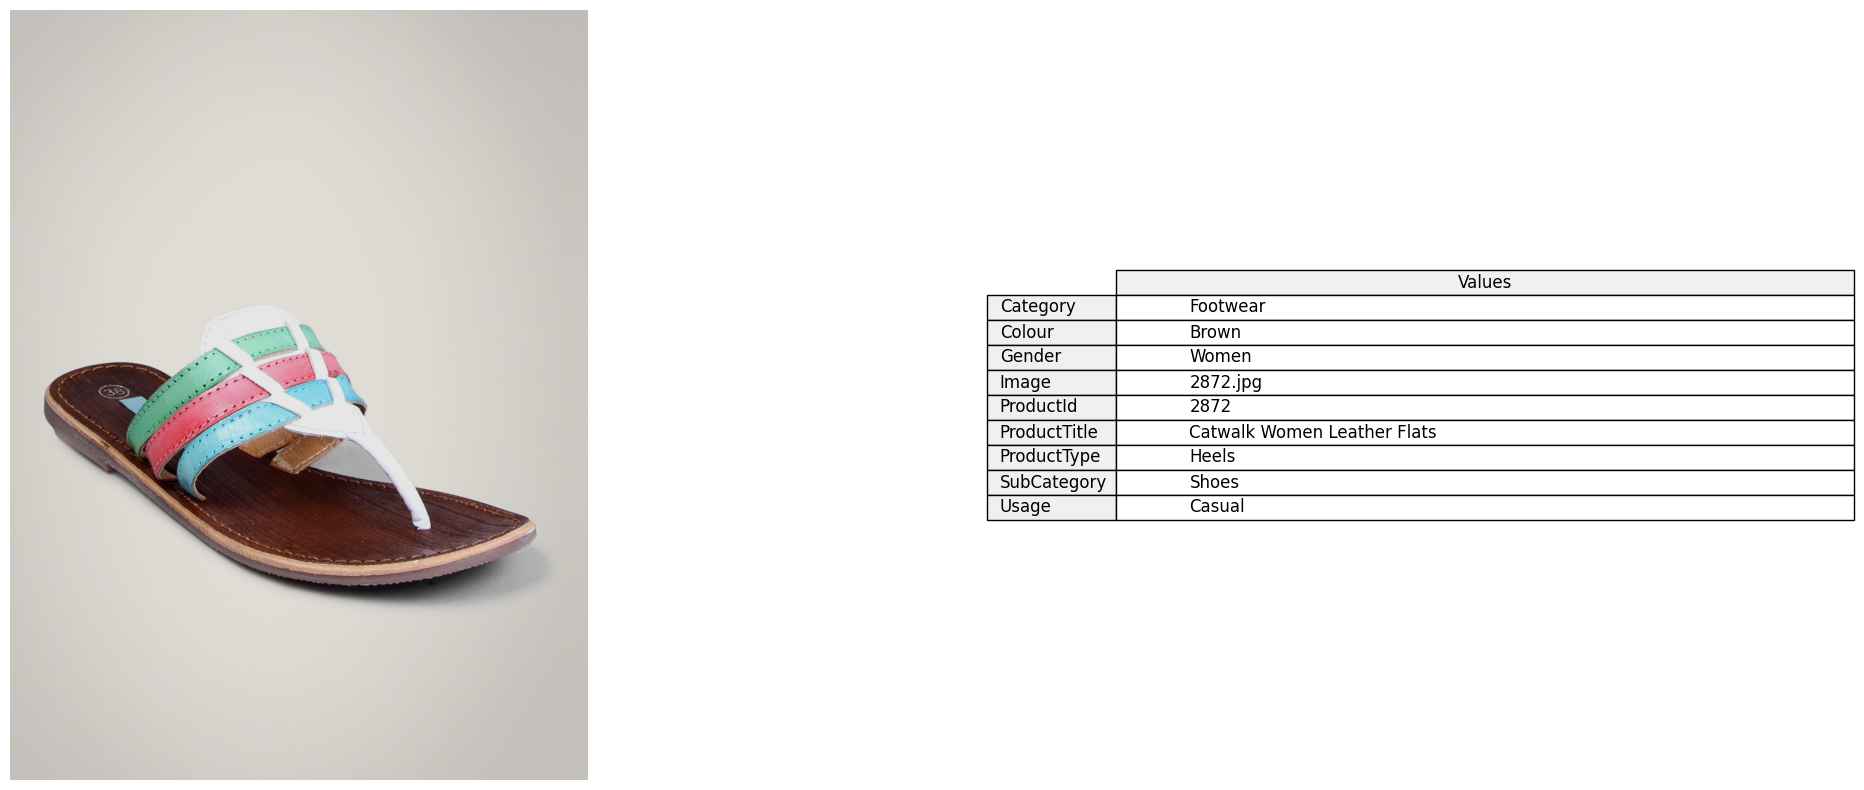

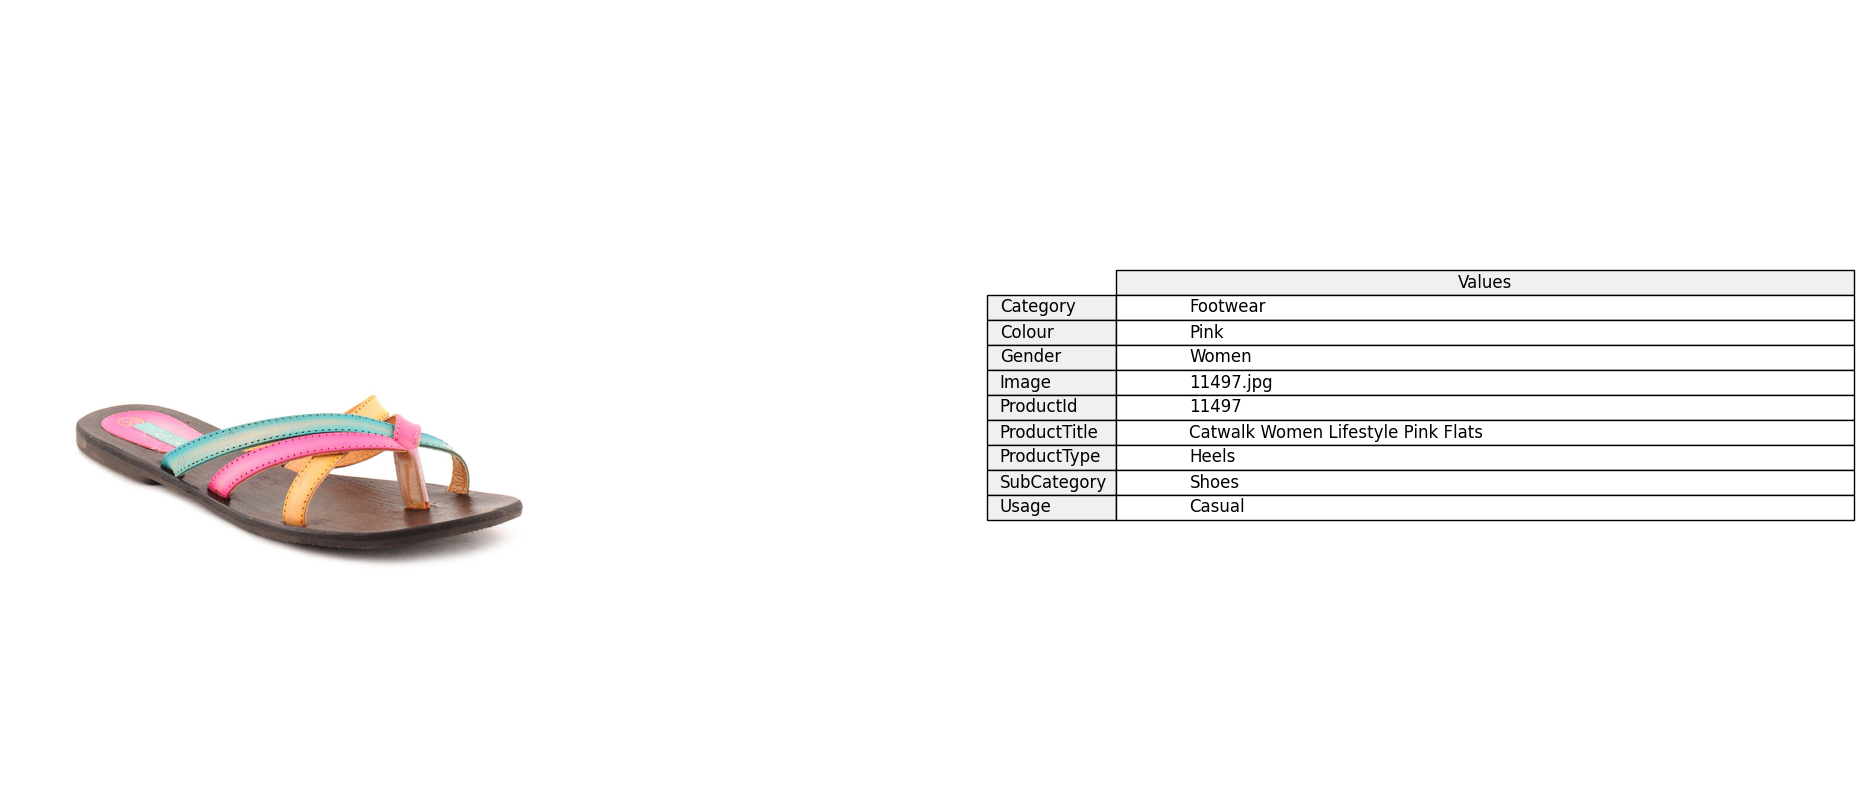

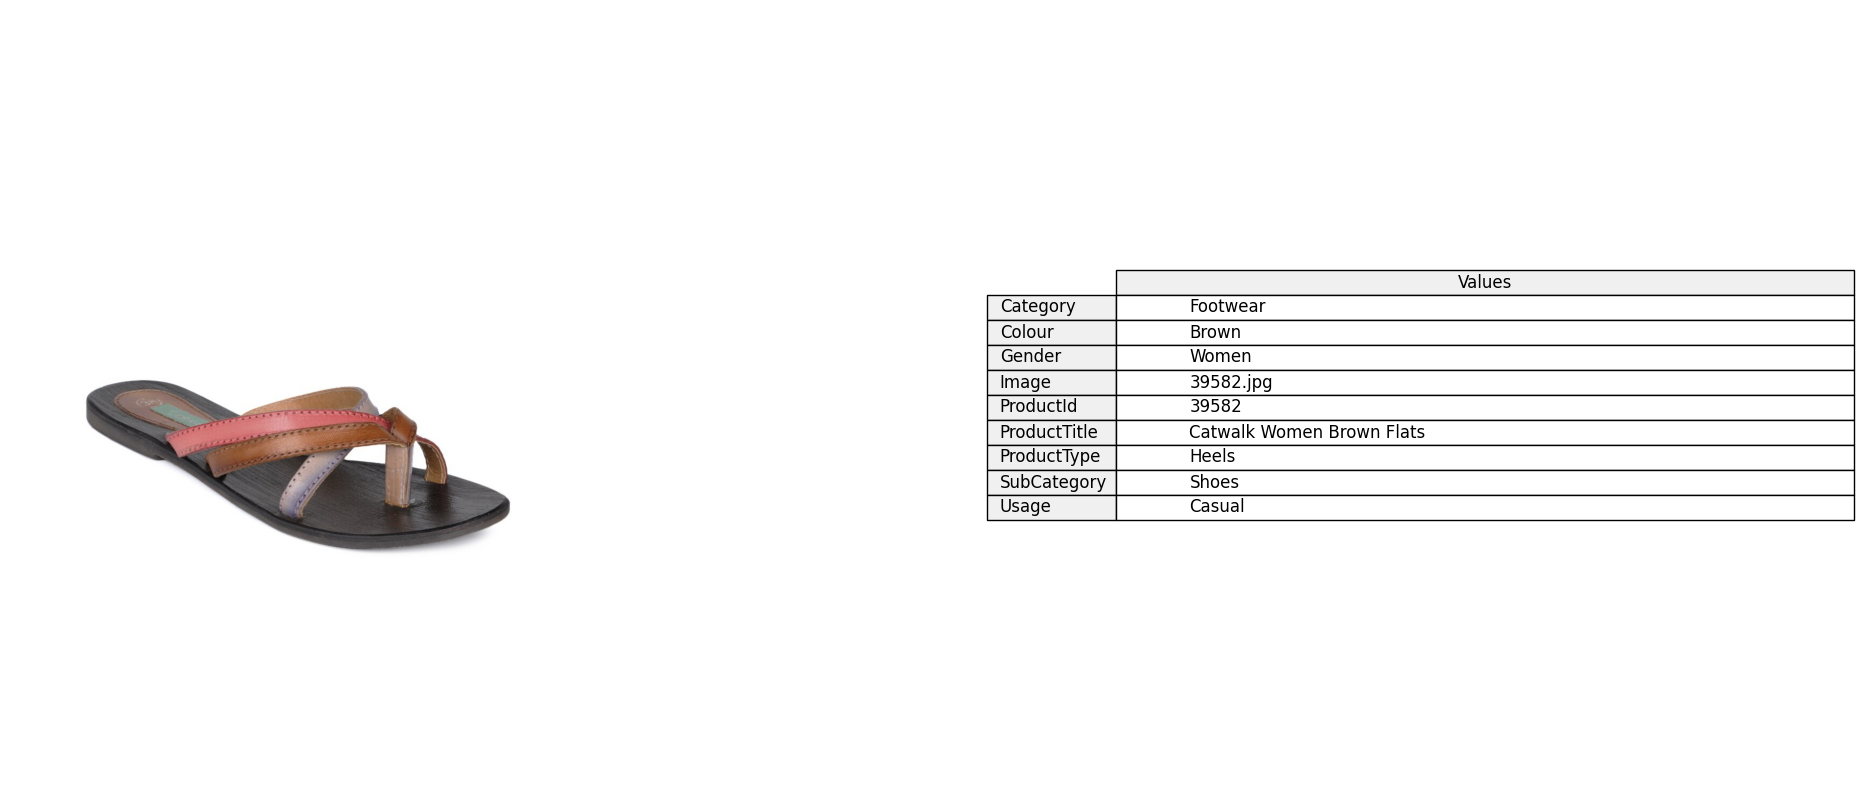

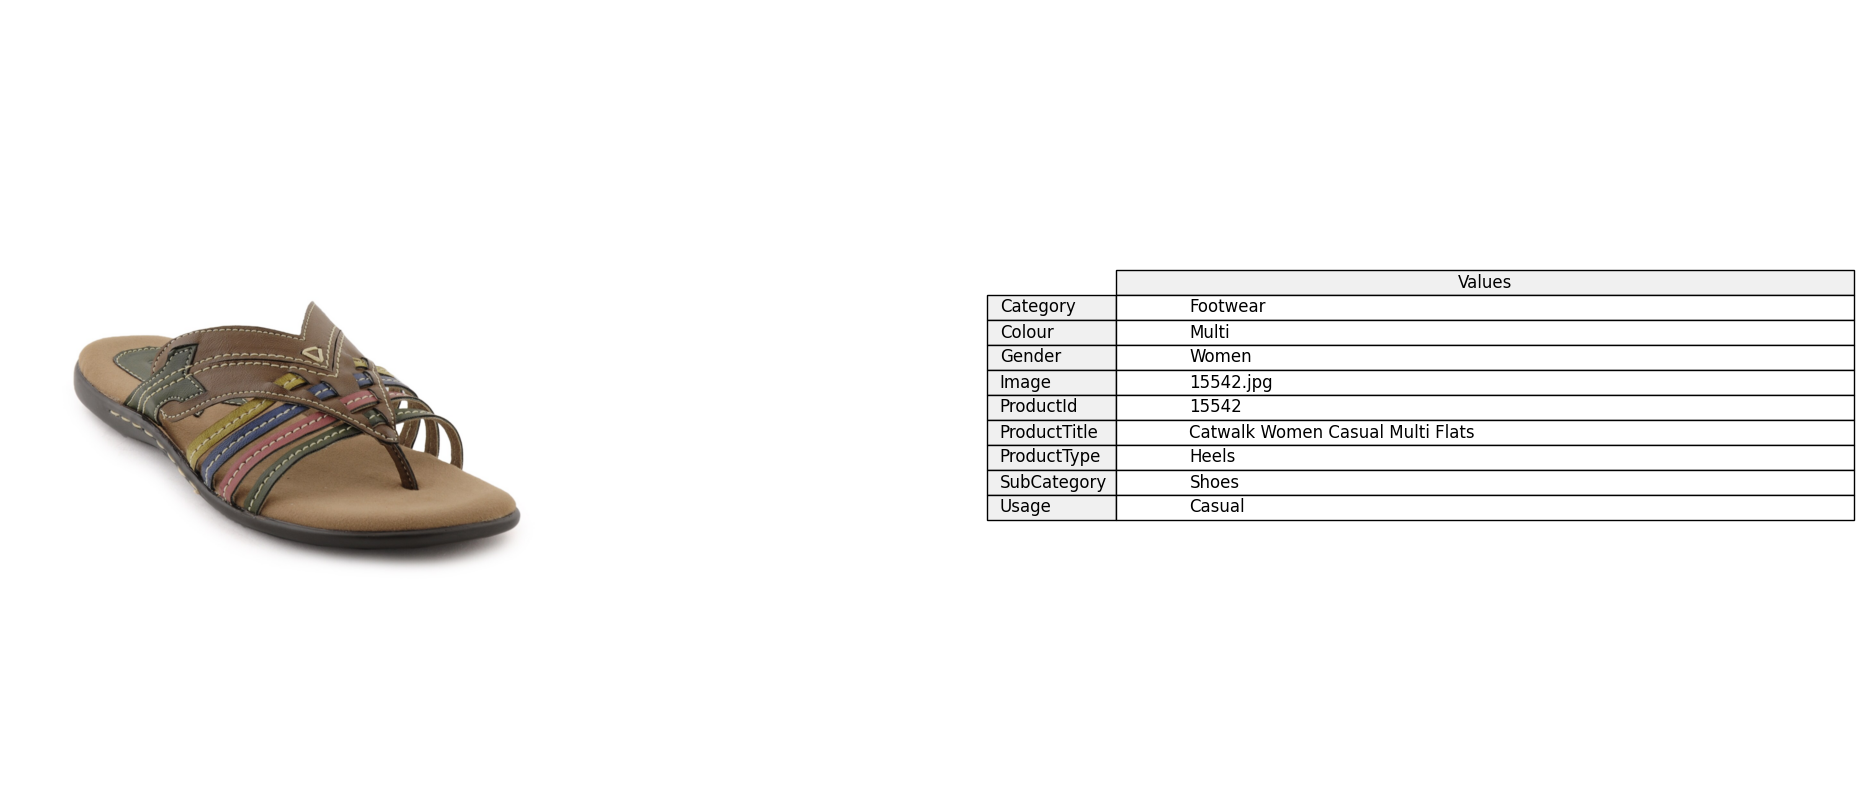

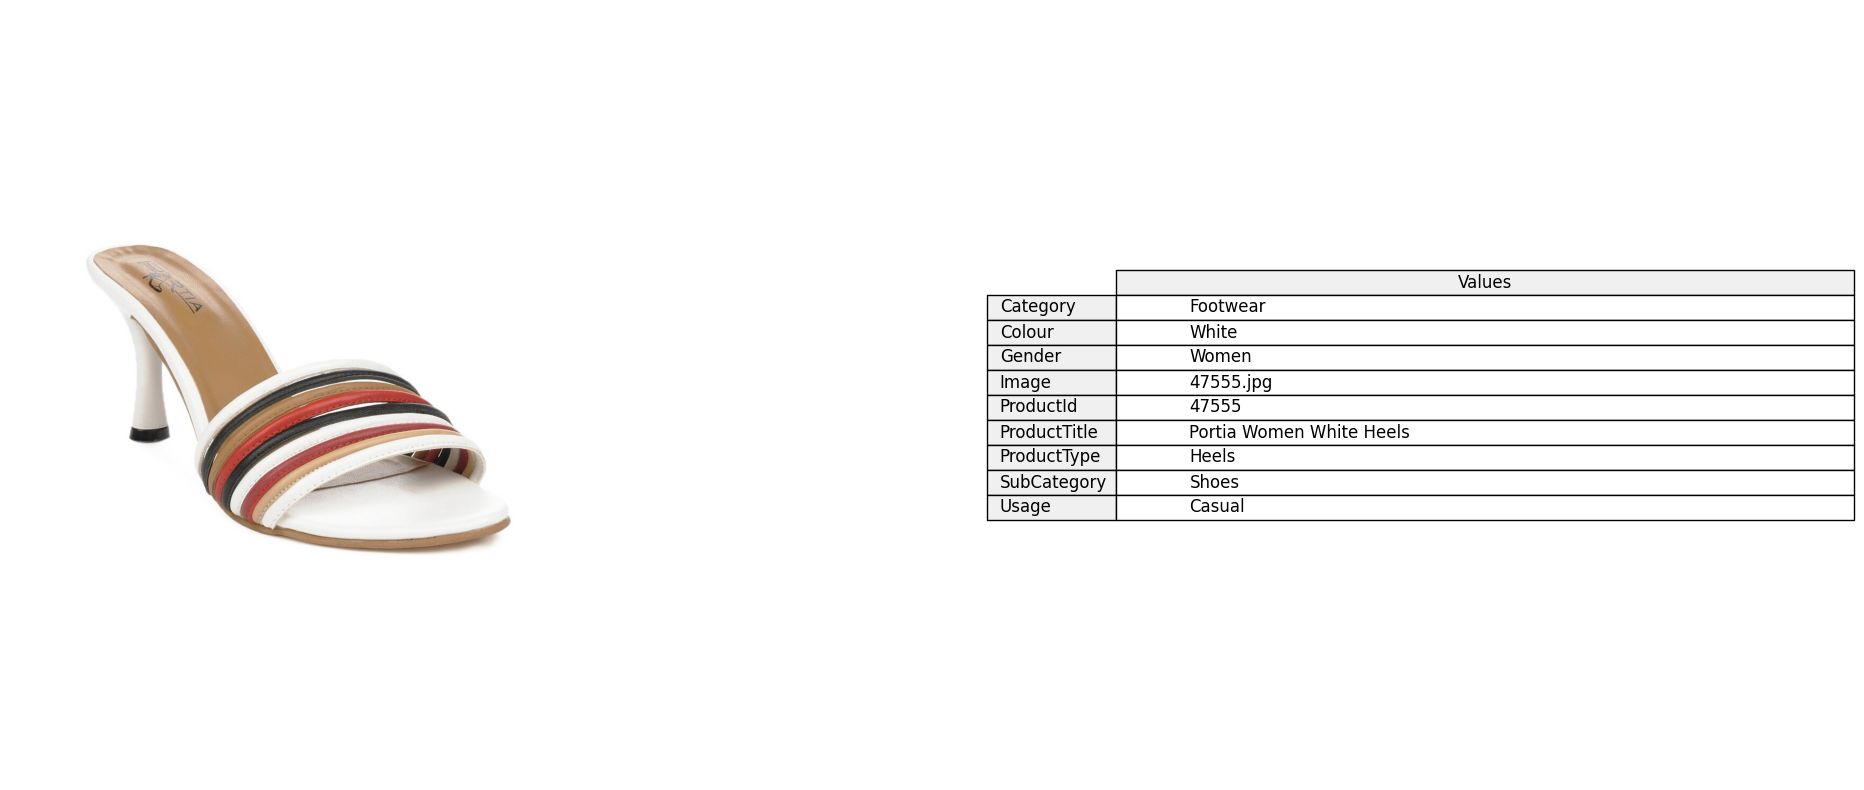

In [16]:
search_by_image(chroma_vector_store,"chappal.jpg",5)

In [17]:
def search_by_query(vec_store, query):
    # First retriever with similarity_score_threshold
    chroma_retreiver = vec_store.as_retriever(
        search_type="similarity_score_threshold", 
        search_kwargs={"k": 5, "score_threshold": 0.1}
    )
    similar_images = chroma_retreiver.invoke(query)

    # If no results, fallback to other methods
    if not similar_images:
        chroma_retreiver = vec_store.as_retriever(
            search_type="mmr", 
            search_kwargs={'k': 5, 'fetch_k': 50}
        )
        similar_images = chroma_retreiver.invoke(query)

    if not similar_images:
        chroma_retreiver = vec_store.as_retriever(
            search_type="mmr", 
            search_kwargs={'k': 5, 'lambda_mult': 0.25}
        )
        similar_images = chroma_retreiver.invoke(query)

    get_images(similar_images)

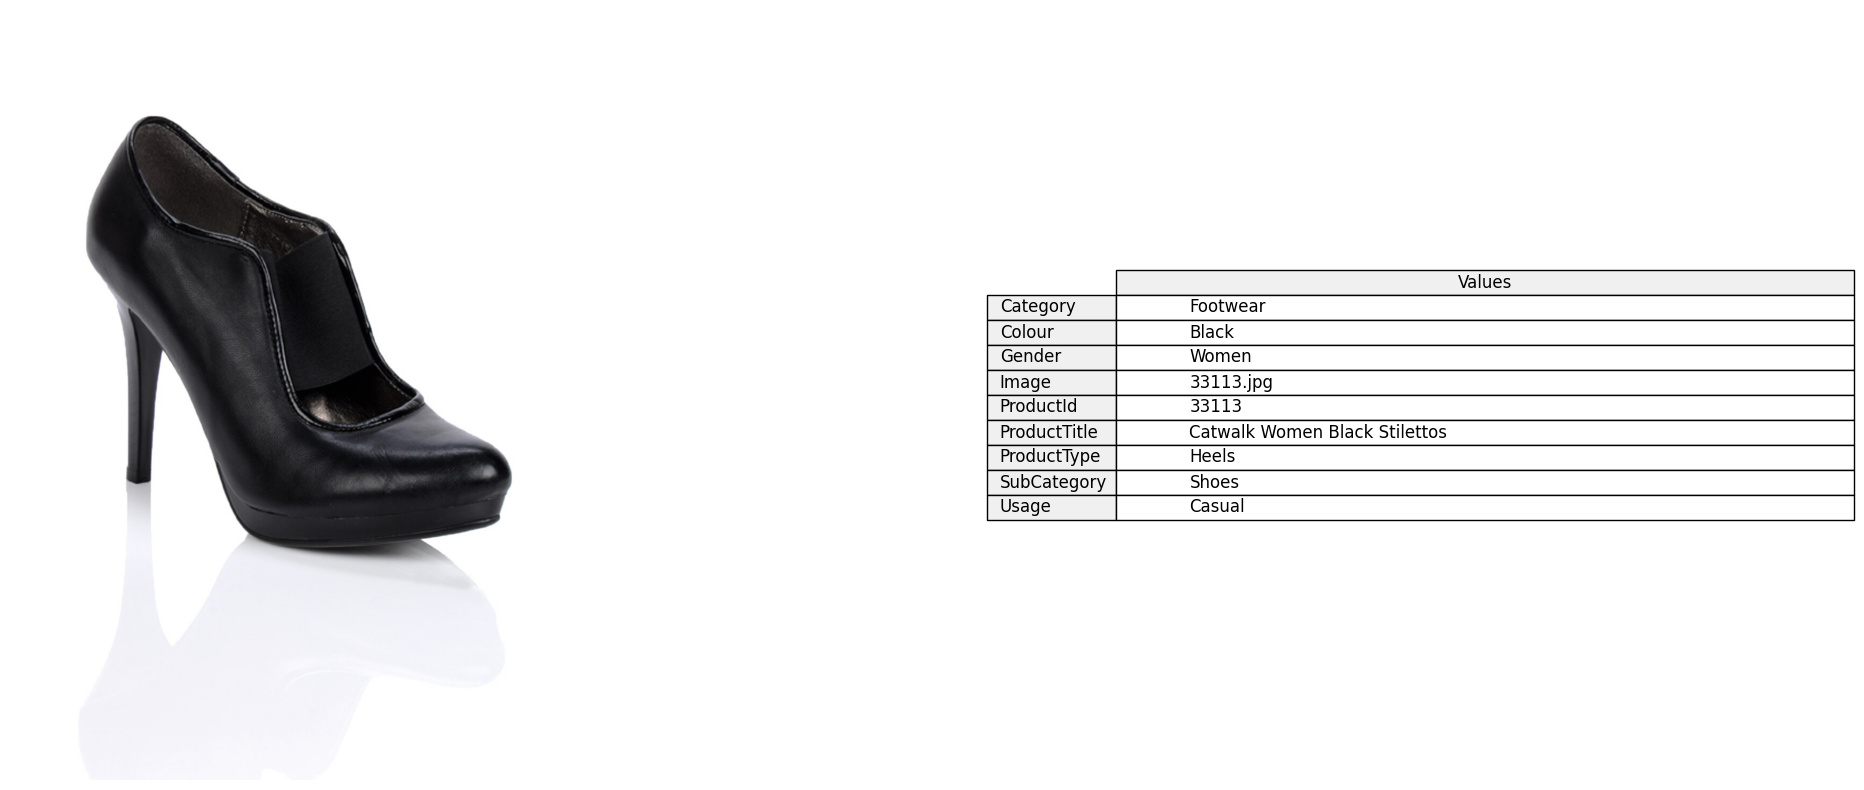

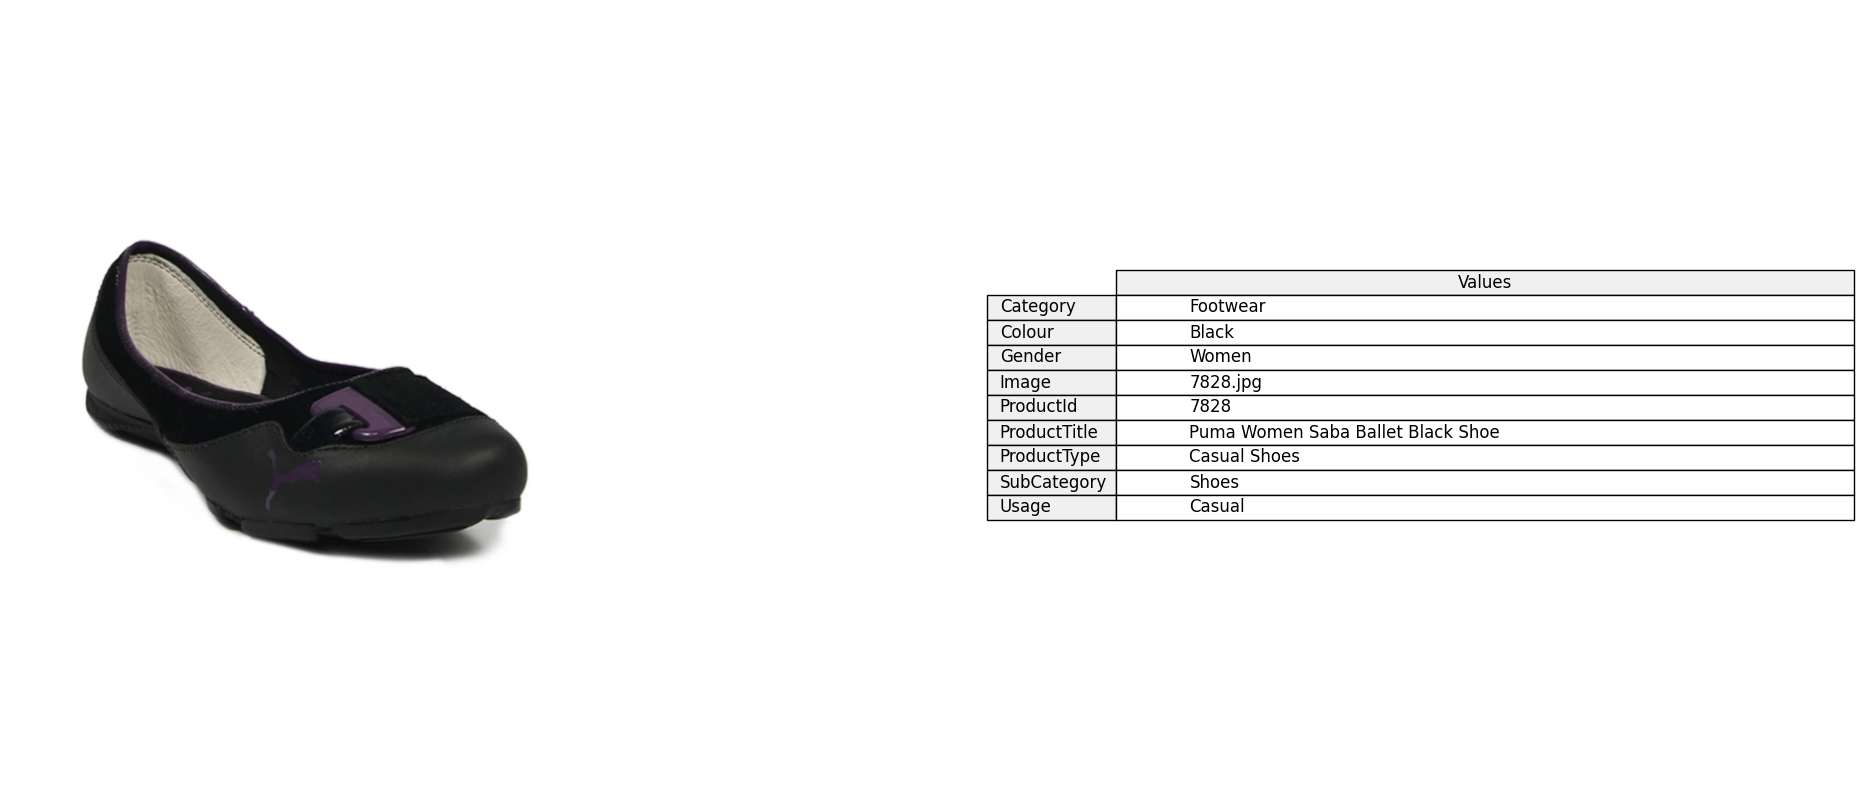

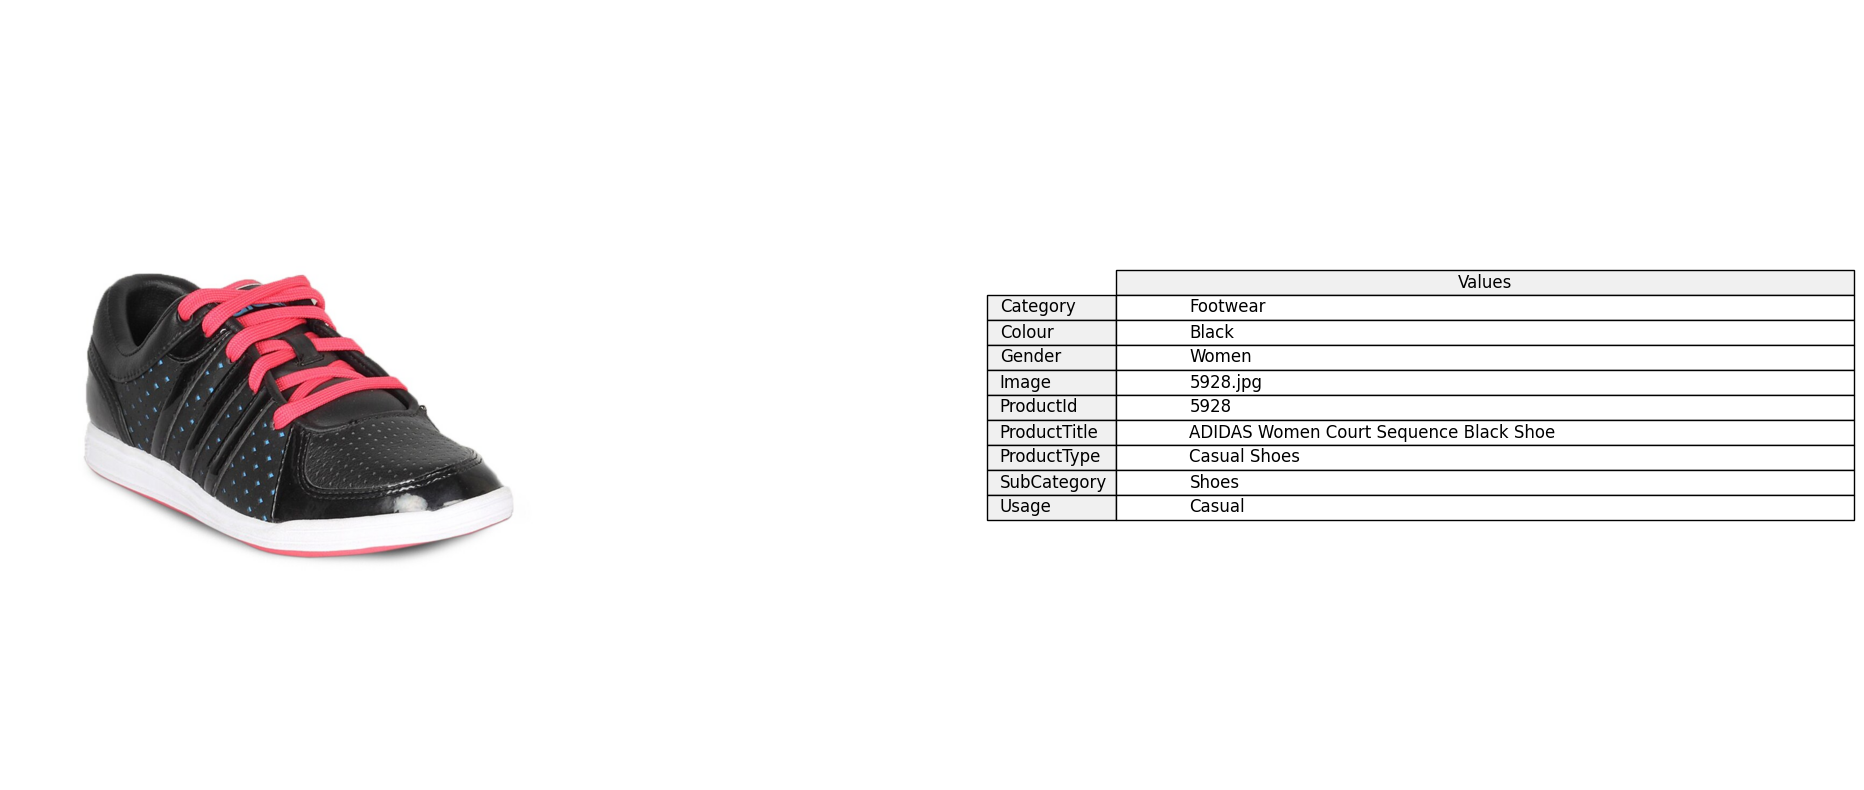

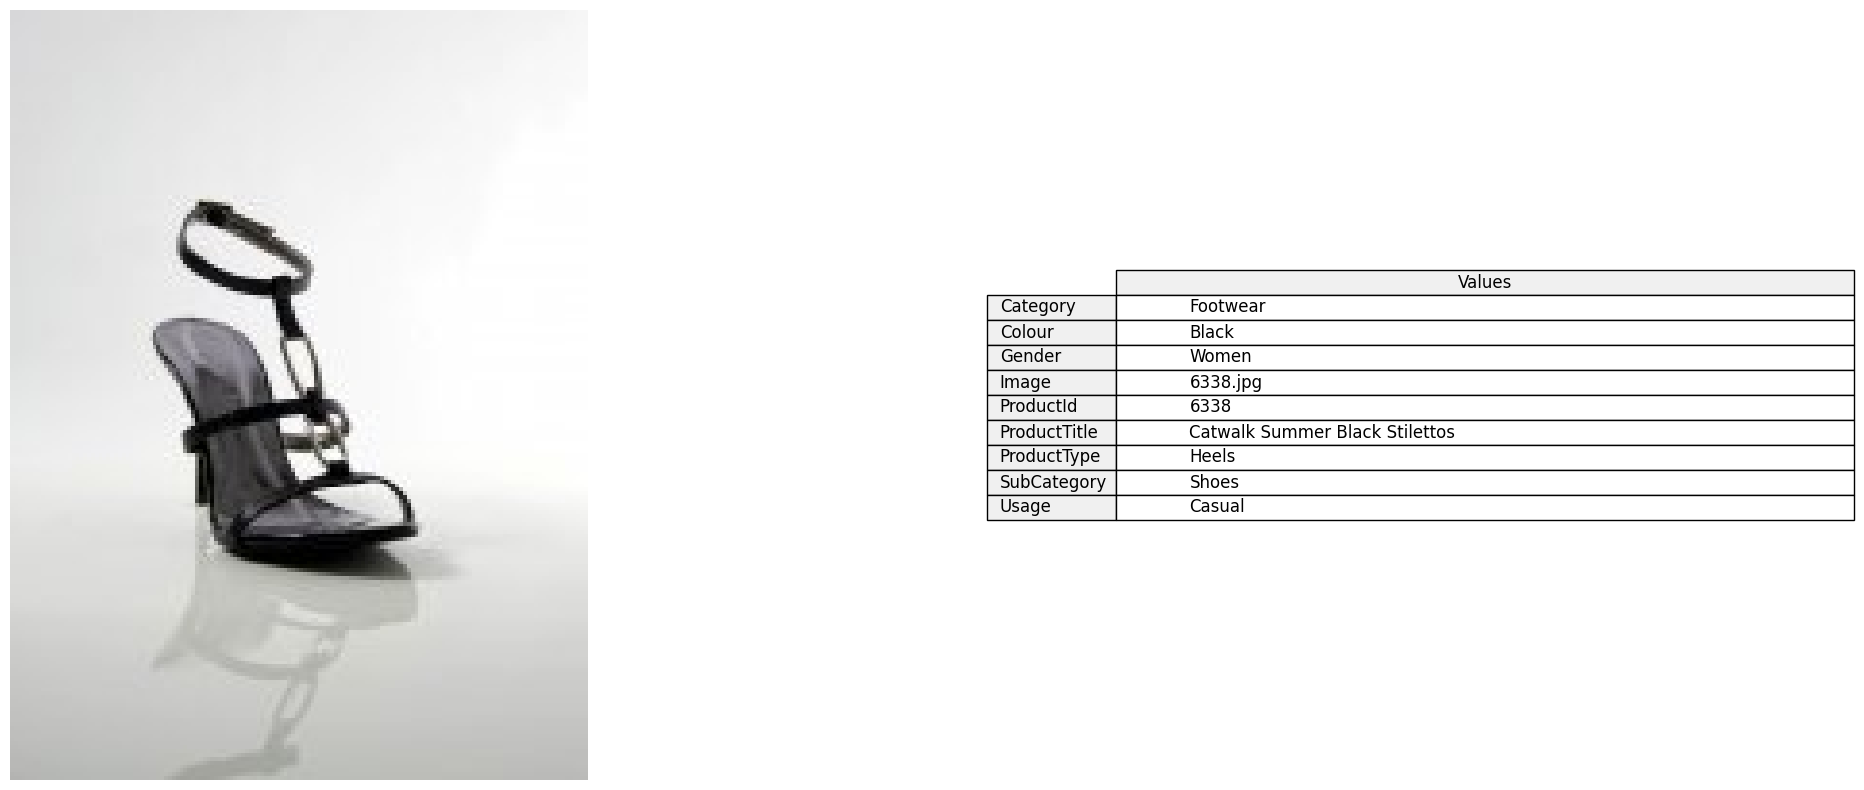

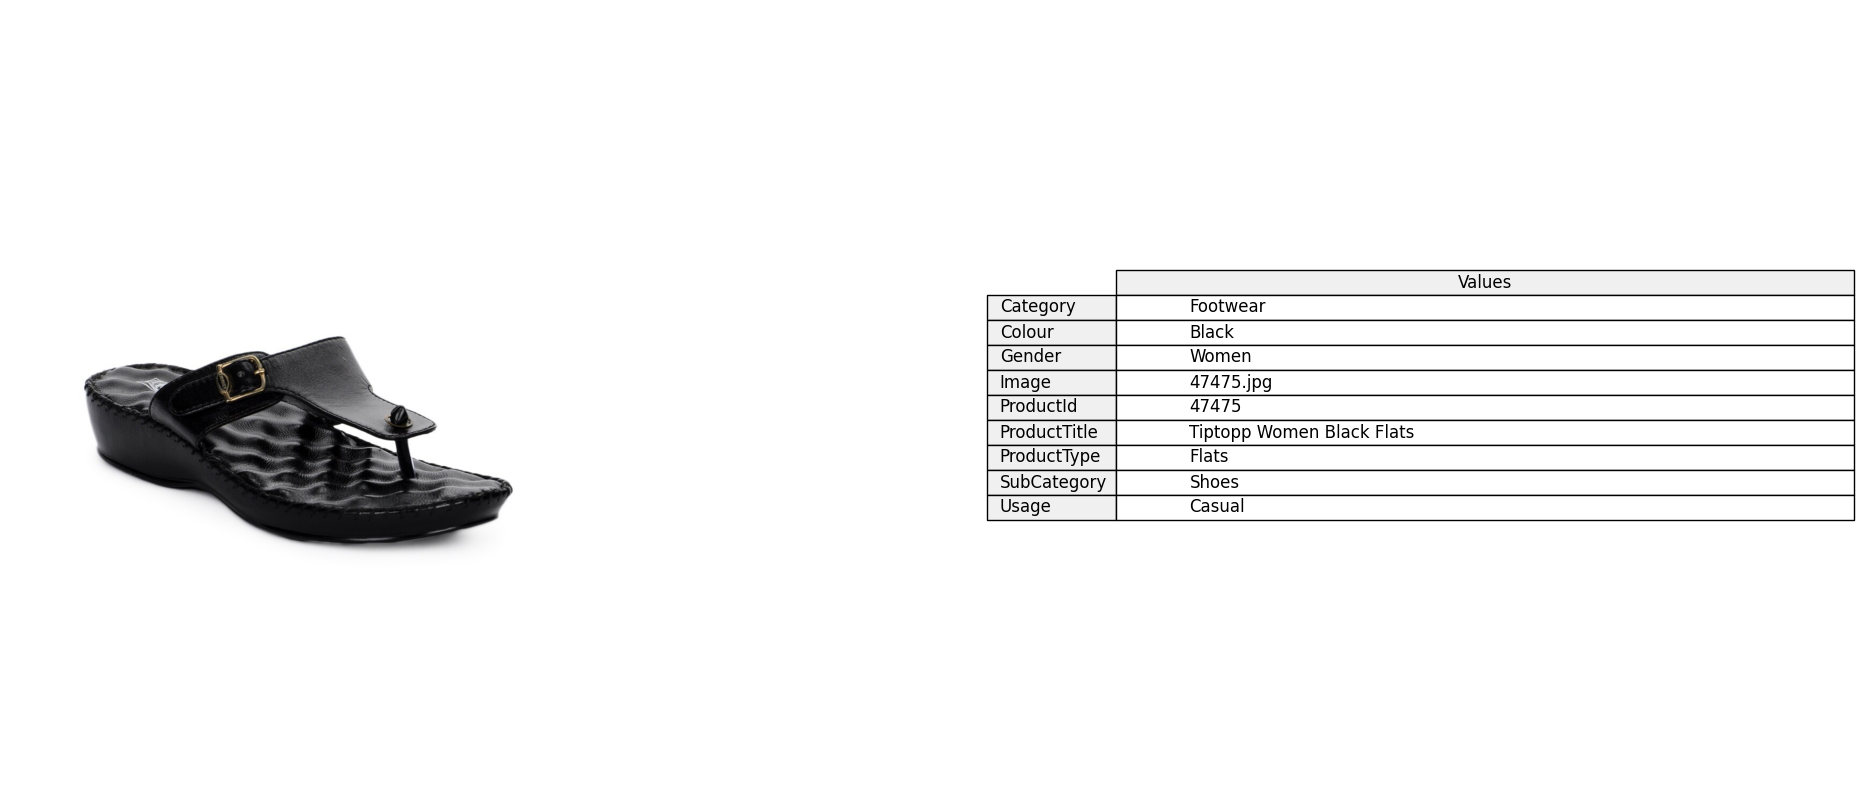

In [18]:
search_by_query(chroma_vector_store,"blck shoes of woman")